# Estimating soil moisture using data assimilation <a id="top"></a>
_Notebook created by Davíd Brakenhoff, Artesia, March 2020_

<hr>

## Goal
The goal of this notebook is to show how soil moisture can be estimated based on soil parameter estimates and data assimilation of soil temperatures measured with DTS. This method uses a custom version of the Hydrus model for the unsaturated zone. This version of the model was modified to incorporate data assimilation. The method was developed by Jianzhi Dong as part of his PhD at Delft University of Technology. 

## Contents
1. [Introduction](#1)
2. [Unsaturated zone model](#2)
3. [Data requirements](#3)
    1. [TAHMO data](#3.1)
    2. [Calibrated DTS temperature data](#3.2)
4. [Writing model input files](#4)
    1. [SELECTOR](#4.1)
    2. [METEO](#4.2)
    3. [ATMOSPH](#4.3)
    4. [PROFILE](#4.4)
    5. [CLM](#4.5)
    6. [DTS temperature observations](#4.6)
5. [Running the model](#5)
6. [Reading the results](#6)

<hr>

## [1. Introduction](#top)<a id="1"></a>
This method aims to estimate soil moisture and temperature in the shallow subsurface by using a numerical model for the unsaturated zone and in-situ observations. The model is based on Hydrus-1D and was modified to assimilate soil temperature measurements at two different depths. Besides measurement temperatures several other parameters relating to soil type and meteorological conditions have to be measured or estimated. Random errors (scaled differently per parameter or timeseries) are added to the input data to generate ensembles. Each ensemble is run through the model, resulting in a range of soil moisture and temperature estimates. 

The method is applied to the data from a measurement campaign in Nyankpala, Ghana between the end of August and beginning of September 2019.

__Note__: This notebook is a work in progress. The code used in this notebook is able to reproduce the results Jianzhi Dong used in his dissertation, but adapting the code to a different case is not yet producing the expected output. This notebook therefore represents the current state of affairs and hopefully provides a clear guide to future users what steps have been taken, and what still needs to be figured out.

<hr>

## [2. Unsaturated zone model](#top)<a id="2"></a>
The unsaturated zone model used for this method is based on Hydrus-1D but was adapted to incoporate data assimilation and a vegetation energy balance scheme. The source code for this model is written in Fortran. In the files obtained from Jianzhi Dong, there were 4 versions of the model:
- RealDTScodes_Dec_23: unsure which version this is, perhaps for testing certain aspects discussed in the first few chapters of Jianzhi Dong's dissertation.
- __RealDTScodes_Dec_23_RealDTS:__ this is the model used in this notebook, the name seems to suggest this model was used to assimilate real DTS data. 
- RealDTScodes_Dec_23DTS: referring to model run using synthetic DTS data?
- RealDTScodes_OL: refers to the open-loop run (see Jianzhi Dong's dissertation)

The source code for the model has to be compiled using the Intel Visual Fortran Compiler. Unfortunately, due to a missing file containing the `GENRANDOM` subroutine, I was unable to compile the code. It seems the file containing this subroutine is missing from the data I received. I therefore used a pre-compiled version of the model.

The model .exe is in the `hydrus_src/bin` directory. I renamed it to hydrus_realdts.exe.

The model code contains hard-coded references to the directory for input and output files, the name of the file containing the DTS measurements, and some other parameters:
- The results directory must be: `C:\`
- The input files must be in the folder: `C:\PassiveRealDTS`
- The DTS data at a location $x$ is stored in a file called `obs_SiteA.txt`
- The number of ensembles is hard-coded to be 300.

<hr>

## [3. Data requirements](#top)<a id="3"></a>
In order to use this method to estimate soil moisture the following data is required:

Timeseries:
- Calibrated DTS temperature observations at 2 different depths
- Air temperature
- Radiation
- Relative humidity
- Wind speed
- Precipitation

Parameters (these are listed and described (where possible) in the [section about writing model input](#4)):
- Soil bulk density
- Percentages sand, clay and silt
- ... and perhaps quite a few more. The important paramters will have to be identified by someone more familiar with Hydrus.

In this section the timeseries data will be read from files. Since we're starting to use Python now, we first need to import some packages:

In [1]:
import os
import sys
import math
from subprocess import PIPE, Popen

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate as interpolate
from tqdm.notebook import tqdm
from scipy.stats import stats
from matplotlib import pyplot

import dtscalibration as dts
from util import get_roeseta_params, smooth
from write_atmosph import write_atmosphere
from write_clm import write_clm
from write_meteo import write_meteo
from write_profile import write_profile
from write_selector import write_selector

C:\Users\CWPGHANA\anaconda3\lib\typing.py:901: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


## [3.1 TAHMO data](#top)<a id="3.1"></a>
This section reads 5-min data downloaded from the portal for TAHMO weather stations. 

In [2]:
# LOAD TAHMO DATA
ftahmo = "C:/PassiveRealDTS/dts_ghana-master/data/tahmo/2020/TA00616.csv"  # PARAM
ftmeta = "C:/PassiveRealDTS/dts_ghana-master/data/tahmo/2020/metadata.csv"  # PARAM

tahmo = df = pd.read_csv(ftahmo, parse_dates=True, index_col=[0])
meta = pd.read_csv(ftmeta).squeeze()

# identify soil moisture and temperature probes
smcols = ['soilmoisture S000988 (m3/m3)',  # middle?
          'soilmoisture S000989 (m3/m3)',  # shallowest?
          'soilmoisture S000990 (m3/m3)']  # deepest

stcols = ['soiltemperature S000988 (degrees Celsius)',  # middle?
          'soiltemperature S000989 (degrees Celsius)',  # shallowest?
          'soiltemperature S000990 (degrees Celsius)']  # deepest

## [3.2 Calibrated DTS temperature data](#top)<a id="3.2"></a>
This section reads in a calibrated DTS temperature dataset. For more information about calibration of DTS data please refer to the calibration notebook.

In [3]:
# dts
channel = "ch1"  # PARAM
calibstr = "ambientearth"  # PARAM
fnetcdf = f"C:/PassiveRealDTS/figdir22102020May2021/calibration/ny_camp1a_{channel}_calib_{calibstr}.nc"  # PARAM
ds = dts.open_datastore(fnetcdf)

In [4]:
ds

C:\Users\CWPGHANA\anaconda3\lib\site-packages\xarray\core\dataarray.py:682: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
C:\Users\CWPGHANA\anaconda3\lib\site-packages\xarray\core\dataarray.py:682: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


<dtscalibration.DataStore>
Sections:
    ambient                ( 26.46 +/- 0.16°C)	10.00 - 25.00 and 1230.00 - 1245.00
    cold                   (  1.96 +/- 0.19°C)	35.00 - 50.00 and 1205.00 - 1220.00
    earth                  ( 29.20 +/- 0.14°C)	620.00 - 635.00
Dimensions:                (CI: 3, mc: 300, params1: 1432, params2: 1432, time: 407, x: 617)
Coordinates:
    filename               (time) object dask.array<chunksize=(407,), meta=np.ndarray>
    timeFWstart            (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeFWend              (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeFW                 (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeBWstart            (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeBWend              (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeBW                 (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timestart              (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeend                (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
  * time                   (time) datetime64[ns] 2020-10-22T10:20:17 ... 2020...
    acquisitiontimeFW      (time) timedelta64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    acquisitiontimeBW      (time) timedelta64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
  * x                      (x) float32 1.452 3.481 5.511 ... 1249.404 1251.433
  * CI                     (CI) float64 2.5 50.0 97.5
  * mc                     (mc) int32 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
Dimensions without coordinates: params1, params2
Data variables:
    probe1Temperature      (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    probe2Temperature      (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    referenceTemperature   (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    gamma_ddf              (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    k_internal             (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    k_external             (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    userAcquisitionTimeFW  (time) timedelta64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    userAcquisitionTimeBW  (time) timedelta64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    ambient                (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    cold                   (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    earth                  (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    st                     (x, time) float32 dask.array<chunksize=(617, 407), meta=np.ndarray>
    ast                    (x, time) float32 dask.array<chunksize=(617, 407), meta=np.ndarray>
    rst                    (x, time) float32 dask.array<chunksize=(617, 407), meta=np.ndarray>
    rast                   (x, time) float32 dask.array<chunksize=(617, 407), meta=np.ndarray>
    gamma                  float64 ...
    alpha                  (x) float64 dask.array<chunksize=(617,), meta=np.ndarray>
    df                     (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    db                     (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    gamma_var              float64 ...
    alpha_var              (x) float64 dask.array<chunksize=(617,), meta=np.ndarray>
    df_var                 (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    db_var                 (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    tmpf                   (x, time) float64 dask.array<chunksize=(617, 407), meta=np.ndarray>
    tmpb                   (x, time) float64 dask.array<chunksize=(617, 407), meta=np.ndarray>
    tmpf_mc_var            (x, time) float64 dask.array<chunksize=(617, 407)

Determine the timesteps for the model from the DTS time.

In [5]:
# time information from DTS
dtstimes = ds.time.to_pandas().values  # DTS times
tstart = pd.Timestamp(dtstimes[0])  # first DTS obs
tend = pd.Timestamp(dtstimes[-1])
# convert to days
dt_in_days = (tend - tstart).total_seconds() / (24 * 60 * 60)

t0 = tstart.floor("D")  # in Hydrus t=0 is midnight, so get midnight before
tstart_num = (tstart - t0).to_numpy() / np.timedelta64(1, "D")
tend_num = tstart_num + dt_in_days
dts_time_num = (dtstimes - t0.to_numpy()) / np.timedelta64(1, "D")

# set model timesteps
mtime = np.arange(tstart_num, tend_num, 1. / 24.)  # hourly steps  # PARAM, hourly steps

<a id="xloc"></a>
Split dataset into shallow and deeper cable. Align sections and pick x-location to perform soil moisture estimate for:

In [6]:
xloc = 250  # PARAM, location to estimate soil moisture

In [7]:
# find alignment of top and bottom cable
xmid = 629  # estimated x-coordinate of middle of the cable (630)
dx = -6 # dx, subtract to align shallow and deeper cables (-7 / -50)

# divide data into shallow and deep section and align
dsc1 = ds.sel(x=slice(-44, xmid))  # deeper section
dsc2 = ds.sel(x=slice(xmid, 1300))  # shallower section (1300)
dsc2 = dsc2.assign(x=(dsc2.x.isel(x=-1)- dsc2.x) - dx)

# get data from bottom and top cables at a point:
dsc1x = dsc1.sel(x=xloc, method="nearest")  # deeper
dsc2x = dsc2.sel(x=xloc, method="nearest")  # shallower

In [8]:
dsc1

C:\Users\CWPGHANA\anaconda3\lib\site-packages\xarray\core\dataarray.py:682: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
C:\Users\CWPGHANA\anaconda3\lib\site-packages\xarray\core\dataarray.py:682: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


<dtscalibration.DataStore>
Sections:
    ambient                ( 26.46 +/- 0.16°C)	10.00 - 25.00 and 1230.00 - 1245.00
    cold                   (  1.96 +/- 0.19°C)	35.00 - 50.00 and 1205.00 - 1220.00
    earth                  ( 29.20 +/- 0.14°C)	620.00 - 635.00
Dimensions:                (CI: 3, mc: 300, params1: 1432, params2: 1432, time: 407, x: 310)
Coordinates:
    filename               (time) object dask.array<chunksize=(407,), meta=np.ndarray>
    timeFWstart            (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeFWend              (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeFW                 (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeBWstart            (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeBWend              (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeBW                 (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timestart              (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    timeend                (time) datetime64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
  * time                   (time) datetime64[ns] 2020-10-22T10:20:17 ... 2020...
    acquisitiontimeFW      (time) timedelta64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    acquisitiontimeBW      (time) timedelta64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
  * x                      (x) float32 1.452 3.481 5.511 ... 626.443 628.472
  * CI                     (CI) float64 2.5 50.0 97.5
  * mc                     (mc) int32 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
Dimensions without coordinates: params1, params2
Data variables:
    probe1Temperature      (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    probe2Temperature      (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    referenceTemperature   (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    gamma_ddf              (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    k_internal             (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    k_external             (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    userAcquisitionTimeFW  (time) timedelta64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    userAcquisitionTimeBW  (time) timedelta64[ns] dask.array<chunksize=(407,), meta=np.ndarray>
    ambient                (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    cold                   (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    earth                  (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    st                     (x, time) float32 dask.array<chunksize=(310, 407), meta=np.ndarray>
    ast                    (x, time) float32 dask.array<chunksize=(310, 407), meta=np.ndarray>
    rst                    (x, time) float32 dask.array<chunksize=(310, 407), meta=np.ndarray>
    rast                   (x, time) float32 dask.array<chunksize=(310, 407), meta=np.ndarray>
    gamma                  float64 ...
    alpha                  (x) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    df                     (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    db                     (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    gamma_var              float64 ...
    alpha_var              (x) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    df_var                 (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    db_var                 (time) float64 dask.array<chunksize=(407,), meta=np.ndarray>
    tmpf                   (x, time) float64 dask.array<chunksize=(310, 407), meta=np.ndarray>
    tmpb                   (x, time) float64 dask.array<chunksize=(310, 407), meta=np.ndarray>
    tmpf_mc_var            (x, time) float64 dask.array<chunksize=(310, 407), 

In [9]:
data1 = dsc1['tmpw'].values
data1

array([[35.05947588, 34.99224406, 35.12971378, ..., 36.08008541,
        36.09208626, 36.15790465],
       [36.37379749, 36.36186872, 36.28015844, ..., 37.33553743,
        37.25049952, 37.38785002],
       [27.50280464, 27.44025423, 27.36386792, ..., 27.91558392,
        27.91247666, 27.93950958],
       ...,
       [28.93967801, 29.02297129, 29.06488546, ..., 29.29830708,
        29.22710705, 29.27865695],
       [28.94993821, 29.05843128, 29.00463617, ..., 29.33937329,
        29.28409782, 29.17424504],
       [29.02297024, 29.11158191, 28.9540593 , ..., 29.18285269,
        29.23523661, 29.27163606]])

In [10]:
data1.sum()

3690452.525330375

In [11]:
t = np.linspace(1, 97517, 126170)
t

array([1.00000000e+00, 1.77289984e+00, 2.54579968e+00, ...,
       9.75154542e+04, 9.75162271e+04, 9.75170000e+04])

In [12]:
P = 97517

In [13]:
a = (2 * math.pi * t / P)
a

array([6.44316920e-05, 1.14230936e-04, 1.64030181e-04, ...,
       6.28308571e+00, 6.28313551e+00, 6.28318531e+00])

In [14]:
vector = np.vectorize(np.float)
x = vector(a)
print(x)

[6.44316920e-05 1.14230936e-04 1.64030181e-04 ... 6.28308571e+00
 6.28313551e+00 6.28318531e+00]


In [15]:
k = print(np.sin(a))

TypeError: only size-1 arrays can be converted to Python scalars

In [52]:
np.size(data2)

126170

In [53]:
np.size(data3)

126170

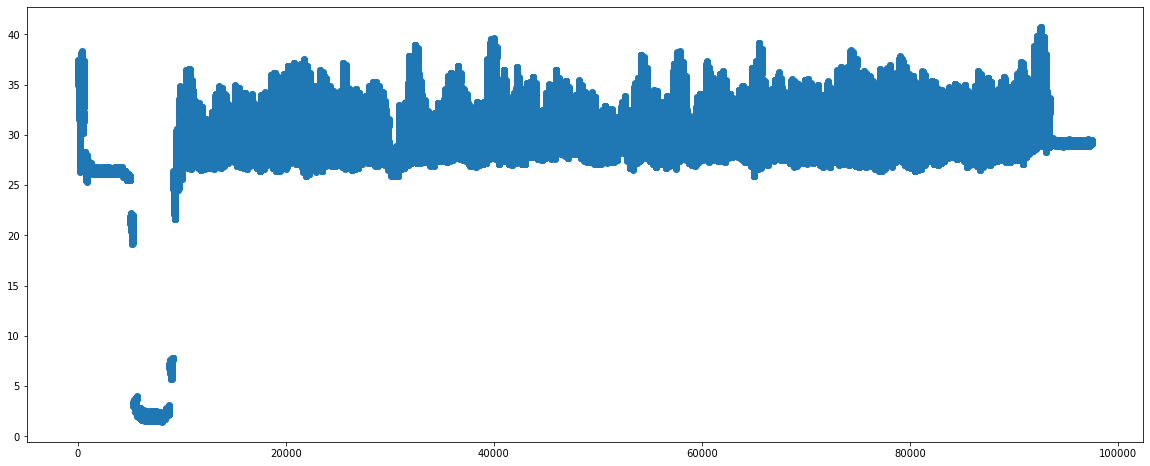

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
pyplot.scatter(data3, data2)
pyplot.show()

In [33]:
data = dsc1['tmpw'].values

In [30]:
dsc1['tmpw'].values.mean()

29.2498416844763

In [31]:
dsc1['tmpw'].values.std()

6.039757714283998

In [32]:
np.size(dsc1['tmpw'].values)

126170

In [34]:
np.std(data, ddof=1) / np.sqrt(np.size(data))

0.01700369031850062

In [35]:
data2 = dsc2['tmpw'].values
data2

array([[28.95740205, 28.97935047, 28.97635787, ..., 29.40950914,
        29.24857495, 29.30988199],
       [28.97447825, 28.96055026, 28.90880633, ..., 29.30522854,
        29.250485  , 29.14274969],
       [29.06077363, 29.05799881, 29.00485172, ..., 29.36779745,
        29.26831541, 29.30707415],
       ...,
       [26.33158113, 26.16649147, 26.36405904, ..., 26.70935999,
        26.75130628, 26.77040393],
       [26.84789725, 26.7270714 , 26.7856371 , ..., 26.98607036,
        27.15020064, 27.06394828],
       [28.50522759, 28.66475746, 28.66677492, ..., 29.21564621,
        29.19730967, 29.32373217]])

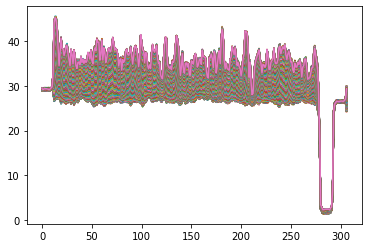

In [36]:
plt.plot(dsc2['tmpw'])
plt.show()

Check alignment:

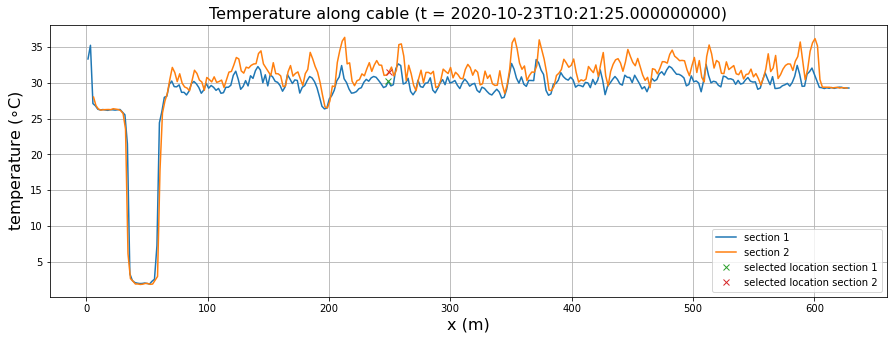

In [7]:
sel_time = 360  # numbered time index, to check alignment

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(dsc1.isel(time=sel_time).x.values,
        dsc1.isel(time=sel_time).tmpw.values, label="section 1")
ax.plot(dsc2.isel(time=sel_time).x.values,
        dsc2.isel(time=sel_time).tmpw.values, label="section 2")
ax.plot(dsc1x.x, dsc1x.isel(time=sel_time).tmpw, "C2x", label="selected location section 1")
ax.plot(dsc2x.x, dsc2x.isel(time=sel_time).tmpw, "C3x", label="selected location section 2")
ax.grid(b=True)
ax.set_xlabel("x (m)", fontsize = 16)
ax.set_ylabel("temperature ($\circ$C)", fontsize = 16)
ax.set_title("Temperature along cable (t = {})".format(
    ds.isel(time=sel_time).time.values), fontsize = 16)
ax.legend(loc='best');

<hr>

## [4. Writing model input files](#top)<a id="4"></a> 

In the following sections the input files are written for running the Hydrus-1D simulation. The requisite data for each file is loaded and written to input files. The required input files are:
- `SELECTOR.IN`: this file contains the basic information about the model
- `METEO.IN`: this file contains the meteorological data (i.e. radiation, windspeed, relative humidity, etc.)
- `ATMOSPH.IN`: this file contains other atmospheric data (i.e. precipitation and air temperature)
- `PROFILE.DAT`: this file contains information about the soil profile
- `CLM.IN`: this file contains information about the vegetation energy balance

First let's run through some general settings:

In [8]:
progress_bar = False  # PARAM, show progress bar when writing files
model_ws = "C:/Users/CWPGHANA/anaconda3/dtscamp2020/DTS_GHANA-GITHUB/scripts/soilmoisture/hydrus_io/"  # PARAM, model workspace directory
hydrus_exe = "C:/Users/CWPGHANA/anaconda3/dtscamp2020/DTS_GHANA-GITHUB/hydrus_src/bin/hydrus_realdts"  # PARAM, path to hydrus executable

The model input and output directories are hard-coded in the hydrus executable we are using. As stated before:
- The results directory must be: `D:\`
- The input files must be in the folder: `D:\PassiveRealDTS`

I am using the windows command `subst <drive letter>: <destination>` to map the folder `.\hydrus_io` (contained in the repository) to the `D:` drive. The model workspace directory for the input files is also created in this folder.

In [9]:
input_ws = "D:/PassiveRealDTS" # hard-coded directory for input files in Hydrus.exe
if not os.path.exists("D:/"):
    # map folder to drive D:/
#     os.system(f"subst D: {model_ws}")
    # create input file directory
    if not os.path.exists(input_ws):
        os.mkdir(input_ws)

The following list allows the user to control which input files are written. By listing only the files you want to write, the user can avoid having to rewrite everything, which saves time. 

Each input file is written `ensemble_size` times (this number is also hard-coded in the hydrus executable).

In [10]:
ensemble_size = 300  # hard-coded in Hydrus executable

In [11]:
writelist = ["METEO", "ATMOSPH", "SELECTOR", "PROFILE", "CLM"]  

### [4.1 SELECTOR](#top)<a id="4.1"></a>

The `SELECTOR.IN` file contains the following information:
- Basic model settings: controls the units used in the model and which modules in the Hydrus model are activated
- Time settings
- Water flow settings
- Material settings
- Heat transport settings

#### Input data

In [12]:
# BASIC INFO for Hydrus 1-D Model operation
latitude = meta["latitude"]
longitude = meta["longitude"]
timezone = +1 # (0)
verbose = False  # for write_functions, if True will print messages when writing files

basic_info = {
    "iVer": 4,
    "Hed": "Written with methods derived from Pydrus 0.0.2",
    "LUnit": "cm", # Checked "cm" under "Length Units" in Geometry Information in Hydrus 1-D Model
    "TUnit": "days", # Checked "days" under "Time Units in Time Information in Hydrus 1-D Model.
    "MUnit": "mmol", # Checked under "Solute Transort" in Hydrus 1-D Model
    "lWat": True, # Selected Water Flow under Main Parameters in Hydrus 1-D Model
    "lChem": False, # Unchecked "Major Ion Chemistry" in the "Main Processes" in Hydrus 1-D Model
    "lTemp": True, # Checked "Temperature Dependence" under Water Flow Parameters in Hydrus 1-D Model
    "lSink": False,
    "lRoot": False, # Unchecked "Root Water Uptake" in the Main Processes in Hydrus 1-D Model
    "lShort": False,
    "lWDep": True, # Checked "Depth of soil profile" under Geometry Information in Hydrus 1-D Model
    "lScreen": False, # Unchecked "Screen output" under "Print information" in Hydrus 1-D Model
    "lVariabBC": True, # Checked "Time-Variable Boundary Cond." in the Time Information in Hydrus 1-D Model
    "lEquil": True, # Checked under "Solute Transport" in Hydrus 1-D Model
    "lInverse": False, # Inverse solution in Hydrus 1-D Model is not selected/checked under "Main processes" in Hydrus 1-D Model
    "lSnow": False, # Unchecked "Snow Hydrology" under "water flow" in the "Main Processes" in Hydrus 1-D Model
    "lHP1": False, # Unchecked "HP1" under "Solute Transport" in the "Main Processes" in Hydrus 1-D Model
    "lMeteo": True, # Checked "Meteorological Data" under Time Information in Hydrus 1-D Model.
    "lVapor": True, # Checked "Vapor Flow" under "water flow" in the "Main processes" in Hydrus 1-D Model
    "lActiveU": False,
    "lFluxes": False, # Unchecked "Print Fluxes" under Print Information in Hydrus 1-D Model
    "lIrrig": False, # "Triggered Irrigation" is inactive under Water Flow BC in Hydrus 1-D Model
    "CosAlpha": 1,
    "lDummy": False
}

In [19]:
# TIME (derived from DTS observations, see earlier code just after loading DTS data)
start_time = tstart_num
end_time = tend_num

time_info = {
    "dt": 0.00347222, # 0.003,For "Initial Time Step" under Time Info. in Hydrus 1-D Model 
    "dtMin":  0.0001, # (0.00001), as "Water Content Tolerance" under Iteration Criteria in Hydrus 1-D Model
    "dtMax": 0.021, #(0.14) For Maximum Time Step under Time Info in Hydrus 1-D Model
    "dMul": 1.3, # Lower Time Step Multiplication Factor under Iteration Criteria in Hydrus 1-D Model
    "dMul2": 0.7, # Upper Time Step Multiplication Factor under Iteration Criteria in Hydrus 1-D Model
    "ItMin": 3, # Value of Lower Optimal Iteration Range inputted under Iteration Criteria in Hydrus 1-D Model
    "ItMax": 7, # Value of Upper Optimal Iteration Range inputted under Iteration Criteria in Hydrus 1-D Model
    "MPL": 1, # Value of "Pressure Head Tolerance" under Iteration Criteria in Hydrus 1-D Model 
    "tInit": tstart_num,
    "tMax": tend_num,
    "lPrintD": False, # 
    "nPrintSteps": 1, # Value inputted at Print Information in Hydrus 1-D Model
    "tPrintInterval": 1, # Value selected under Print Information in Hydrus 1-D Model
    "lEnter": True, # Checked under Print Information in the Hydrus 1-D Model
}

# not sure entirely what this is used for
times_list = [dt_in_days]

In [20]:
# MATERIALS 
# This information is updated with info from Rosetta in Jianzhi Dong's script.
# Since I do not have a working copy of this Rosetta executable, I have defined these parameters here.
# The write code below has a commented section showing how these parameters can be updated if Rosetta 
# is made to work.
materials_df = pd.DataFrame(columns=["thr", "ths", "Alfa", "n", "Ks", "l"],
                            data=[[0.065, 0.41, 0.075, 1.89, 106.1, 0.5]], # [0.062, 0.399, 0.0119, 1.48, 13.092, 0.5]
                            index=[0])
materials = {"water": materials_df}

In [21]:
# WATER FLOW
water_flow = {
    "MaxIt": 1300,
    "TolTh": 0.010,
    "TolH": 5,
    "TopInf": True,
    "WLayer": True, # Atmospheric BC with surface layer under Water Flow BC in Hydrus 1-D
    "KodTop": -1,
    "InitCond": True, # Checked "Initial Water Contents" under Initial Condition of Water Flow BC in Hydrus 1-D Model
    "BotInf": False,
    "qGWLF": False,
    "FreeD": True, # Checked "Free Drainage" under Water Flow BC in Hydrus 1-D Model
    "SeepF": False, # "Seepage Face" is not checked under "Water Flow BC"in Hydrus 1-D
    "KodBot": -1,
    "DrainF": False, # Unchecked "Deep Drainage" under Water Flow BC in Hydrus 1-D Model
    "hSeep": 0, # "Max h at Soil Surface (= 0)" under Water Flow BC in Hydrus 1-D Model (= 0 anyways)
    "hTab1": 1e-005, # Value of "Lower Limit of the Tension Interval (cm)" under Iteration Criteria in Hydrus 1-D Model
    "hTabN": 100000, # Value of "Upper Limit of the Tension Interval (cm)" under Iteration Criteria in Hydrus 1-D Model
    "Model": 0,
    "Hysteresis": 0, # Unchecked "No Hysteresis" under Soil Hydraulic Model in Hydrus 1-D Model 
}

In [16]:
# HEAT TRANSPORT
heat_transport_info = {
    "tAmpl": 0, # "Temperature Ampliture (= 0)" under Heat Transport Parameters in Hydrus 1-D
    "tPeriod": 0, # "Interval for one temp. cycle (day) (= 0)" under Heat Transport Parameters in Hydrus 1-D 
    "Campbell": 2, # "Campbell" checked under Heat Transport Parameters in Hydrus 1-D
    "SnowMF": 0.43,
    "kTopT": -1,
    "TTop": 20,
    "kBotT": 0,
    "TBot": 20
}

heat_params = pd.DataFrame(columns=["Qn", "Qo", "Disper.", "B1", "B2", "B3", "Cn", "Co", "Cw"],
                           data=[[0.60, 0, 0.001000, 3.731290e-01, 5.194220e-01, 1.666762e+00,
                                  183327000000000, 187370000000000, 312035000000000]],
                           index=[0]) 
# [0.60, 0, 0.001000, 3.731290e-01, 5.194220e-01, 1.666762e+00, 183327000000000, 187370000000000, 312035000000000]

#### Write the SELECTOR file(s). 
There is some logic happening here related to soil parameters that I do not yet fully understand. The function `get_roeseta_params()` is supposed to calculate parameters based on some input values, but since this executable is not working I am using the same `resul.txt` file that was provided with Jianzhi Dong's data every time.

# sand, clay and silt percentage 

In [17]:
if "SELECTOR" in writelist:
    # sand, clay and silt percentage
    sand_percentage = np.random.rand(ensemble_size)
    cor = 0.0
    sand = sand_percentage * 55 + 20  # (55 + 10)
    silt = (100 - sand) * (0.9 * np.random.rand() + 0.1)
    clay = 100 - silt - sand
    
    # bulk density estimate
    bulk_density = 1.2 + 0.5 * (sand_percentage * 0.3 + (1 - cor) * np.random.rand()) # (0.5 to 0.5, and 0.3 to 0.3)

    # alpha bounds
    alpha1 = np.array([0, 100])
    alpha2 = np.array([0.27, 0.96])
    
    # interpolator function using univariate spline
    spl = interpolate.UnivariateSpline(alpha1, alpha2, k=1)
    
    # create <ensemble_size> files
    for i in (tqdm(range(ensemble_size), desc="SELECTOR") if progress_bar
              else range(ensemble_size)):
        
        # Get soil characteristics (I think only porosity?) from Rosetta? 
        # I'm not entirely sure yet what is being calculated in this section...
        # TODO: get_roeseta_params() IS NOT WORKING! ALWAYS GETS THE SAME FILE resul.txt
        # which I took from Jianzhi Dong's files
        soil_hydrology = get_roeseta_params(sand[i], silt[i], bulk_density[i],
                                            "cm", "day")
        
        # Jianzhi Dong uses soil_hydrology calculated above as input for the materials dictionary, 
        # I have left that out for now. But the commmented code below shows how that would work:
        # materials_df = pd.DataFrame(columns=["thr", "ths", "Alfa", "n", "Ks", "l"],
        #                     data=np.atleast_2d(soil_hydrology),
        #                    index=[0])
        # the key 'water' is used because the write_method I took from Pydrus contains a hard-coded reference to it.
        # materials = {"water": materials_df}  
                
        porosity = 1 - soil_hydrology[1]
        alpha = spl(sand[i])
        
        q = sand[i] / 100
        if q < 0.2:
            lab_0 = 3
        else:
            lab_0 = 2

        lab_w = 0.594  # water
        lab_q = 7.7  # quartz?

        lab_s = lab_q**q * lab_0**(1 - q)
        lab_sat = lab_s**porosity * lab_w**(1 - porosity)  # saturated thermal conductivity?
        
        # soil thermal properties (I am unsure what these parameters represent exactly)
        soil_thermal = np.array([porosity,
                                 0.,
                                 0.001,
                                 q,
                                 alpha,
                                 lab_sat,
                                 1.83327e+014 * 1.,
                                 1.8737e+014,
                                 3.12035e+014])

        # write selector.in
        write_selector(basic_info, time_info, times_list, water_flow,
                       materials, heat_transport_info, heat_params,
                       n_materials=1, n_layers=1,
                       fname=f"SELECTOR_LU{i+1}.IN", ws=input_ws,
                       verbose=verbose)

In [18]:
bulk_density.mean()

1.6054371511784282

### [4.2 METEO](#top)<a id="4.2"></a>
The `METEO.IN` file contains the following information:
- Settings about the meteorological information (see dictionary below)
- Timeseries:
    - time (timestamps of measurements below): "t"
    - radiation: "Rad"
    - maximum temperature: "TMax"
    - minimum temperature: "TMin" 
    - relative humidity: "RHMean"
    - windspeed: "Wind"
    - sun hours: "SunHours" (was set to a constant value of 0.6 by Jianzhi Dong in his script)
    - crop height: "CropHeight" (not filled in)
    - albedo: "Albedo" (not filled in)
    - leaf area index: "LAI(SCF)" (not filled in)
    - ?: "rRoot" (not filled in)
    
__Note:__ The units of the different timeseries have to be entered correctly (i.e. time in days, windspeed in km/day).

#### Input data

In [19]:
# METEO
meteo_info = {
    "Radiation": 1,
    "Penman-Hargreaves": "f", # Unchecked Penman-Hargreaves under Meteo. Data in Time Info in Hydrus 1-D
    "lEnBal": True, # Checked Energy Balance BC under Meteo. Data in Time info in Hydrus 1-D
    "lDaily": False, # Unchecked Daily Variation of Meteo. Data ... in Time Info in Hydrus 1-D
    "Latitude": latitude,
    "Altitude": meta["elevation (m)"],
    "ShortWaveRadA": 0.25,
    "ShortWaveRadB": 0.50,
    "LongWaveRadA": 0.90,
    "LongWaveRadB": 0.10,
    "LongWaveRadA1": 0.34,
    "LongWaveRadB1": -0.139,
    "WindHeight": 2.50, # (250)
    "TempHeight": 2.50, # (250)
    "iCrop": 0,
    "SunShine": 3,
    "RelativeHum": 0,
    "cloud": [0.55, -0.35],
    "Albedo": 0.15, # (0.23)
}

#### Write the METEO file(s)
Note the random errors being added to some of the timeseries and the smoothing being applied to data.

In [20]:
if "METEO" in writelist:
    meteodata = tahmo.loc[tstart:tend]
    
    # create dataframe containing relevant data
    cols = ["t", "Rad", "TMax", "Tmin", "RHMean", "Wind"]
    meteodf = pd.DataFrame(columns=cols, index=range(meteodata.index.size))
    meteodf["t"] = (
        meteodata.index - t0).total_seconds().to_numpy() / (24 * 60 * 60)
    meteodf["TMax"] = meteodata['temperature (degrees Celsius)'].values
    meteodf["TMin"] = meteodata['temperature (degrees Celsius)'].values
    meteodf["SunHours"] = 0.6
    meteodf["Rad"] = meteodata['radiation (W/m2)'].values
    meteodf['RHMean'] = meteodata['relativehumidity (-)'].values
    # convert from m/s to km/day
    meteodf["Wind"] = meteodata['windspeed (m/s)'].values * (24 * 60 * 60) / (1e3)        
        
    # reorder columns and fill NaNs with blanks
    reorder = ["t", "Rad", "TMax", "TMin", "RHMean", "Wind",
               "SunHours", "CropHeight", "Albedo", "LAI(SCF)", "rRoot"]
    meteodf = meteodf.reindex(columns=reorder, fill_value="")

    # create <ensemble_size> files
    for i in (tqdm(range(ensemble_size), desc="METEO") if progress_bar
              else range(ensemble_size)):
        meteo_ens = meteodf.copy()
        m, n = meteo_ens.shape
        
        # add random noise to some input timeseries
        meteo_ens["Rad"] = (meteo_ens["Rad"] *
                            (1 + 0.075 * np.random.randn(m))) #.clip(upper=114)
        meteo_ens["TMax"] = meteo_ens["TMax"] + 0.5 * np.random.randn(m)
        # TMin remains the same
        meteo_ens["RHMean"] = (meteo_ens["RHMean"] *
                               (1 + 0.1 * np.random.randn(m))).clip(upper=100)
        meteo_ens["Wind"] = meteo_ens["Wind"] + (1 + 0.1 * np.random.randn(m))
        # Sunhours remains the same

        # smooth
        # MATLAB script uses 4 as second param, but it's changed to 3 internally
        meteo_ens["Rad"] = smooth(meteo_ens["Rad"], 3)
        for col in ["TMax", "TMin", "RHMean", "Wind", "SunHours"]:
            # MATLAB uses 8, but it is 7 (see reason in comment above)
            meteo_ens[col] = smooth(meteo_ens[col], 7)

        # write METEO.IN file
        write_meteo(basic_info, meteo_info, meteo_ens, fname=f"METEO{i+1}.IN",
                    ws=input_ws, verbose=verbose)

### [4.3 ATMOSPH](#top)<a id="4.3"></a>

The `ATMOSPH.IN` file contains the following information:
- Settings about something atmospheric
- Timeseries:
    - precipitation

In [21]:
# ATMOSPHERE
atmosphere_info = {
    "lDailyVar": False, # Unchecked "Daily Variation of Meteo. Data ..." under Time Info in Hydrus 1-D Model
    "lSinusVar": False, # Unchecked "Sinusoidal variation of ppt ..." under Time Info in Hydrus 1-D
    "lLai": False, # Unchecked "LAI/Surface Fraction" under Crop Data in Meteo. Parameters in Hydrus 1-D Model
    "lBCCycles": False, # Unchecked "Repeat BC records n times" under Time Info in Hydrus 1-D
    "lInterc": False, # "Interception" is inactive but default value (= 1.5) in Meteo. Parameters in Hydrus 1-D Model
    "lExtinct": 0.463, # "Radiation Extinction with default value = 0.463" is inactive in Meteo. Parameters in Hydrus 1-D Model
    "hCritS": 0,
}

#### Write the ATMOSPH files

In [22]:
if "ATMOSPH" in writelist:
    atmodata = tahmo.loc[tstart:tend]
    
    # create dataframe
    # in MATLAB 11 columns are written, but ATMOSPH.IN file has 12:
    # filling in 0.0 in last column, assuming it won't matter...
    cols = ["tAtm", "Prec", "rSoil", "rRoot", "hCritA",
            "rB", "hB", "hTop", "tBot", "Ampl", "RootDepth"]
    atmodf = pd.DataFrame(index=atmodata.index, columns=cols, data=0.0)
    # set data 
    atmodf["tAtm"] = (
        atmodata.index - t0).total_seconds().to_numpy() / (24 * 60 * 60)
    # prec is mm per 5 minutes: convert to cm/day
    atmodf["Prec"] = atmodata.loc[:, 'precipitation (mm)'] * (12 * 24) / 10
    atmodf["hCritA"] = (1e6)
    
    # create <ensemble_size> files
    for i in (tqdm(range(ensemble_size), desc="ATMOSPH") if progress_bar
              else range(ensemble_size)):
        atmo_ens = atmodf.copy()
        m, n = atmo_ens.shape
        # multiply precipitation with random factor > 1
        atmo_ens["Prec"] *= (1 + 0.1 * np.random.randn(m))

        # write ATMOSPH.IN file
        write_atmosphere(basic_info, atmosphere_info, atmo_ens,
                         fname=f"ATMOSPH{i+1}.IN", ws=input_ws, verbose=verbose)

### [4.4 PROFILE](#top)<a id="4.4"></a>
The `PROFILE.DAT` file contains information about the soil profile:
- the number of layers in the model
- for which nodes (layers) results are stored

#### Input data

In [23]:
# PROFILE
nlay = 101

# presumably the nodes at which output is stored in the output
obs_nodes = [1, 5, 10, 15, 25, 50]

# initial states soil temperature and moisture at top and bottom of profile
soiltemp_top_init = 29.2 # (27.8)
st_top_randomfactor = 2.0  # for scaling random added values
soiltemp_btm_init = 29.3 # (23)
st_btm_randomfactor = 1.0  # for scaling random added values
soilmois_top_init = 0.246 # (0.22)
sm_top_randomfactor = 0.10  # for scaling random added values
soilmois_btm_init = 0.262 # (0.30)
sm_btm_randomfactor = 0.01  # for scaling random added values

#### Write the PROFILE files

In [24]:
if "PROFILE" in writelist:

    # column names
    cols = ['x', 'h', 'Mat', 'Lay', 'Beta',
            'Axz', 'Bxz', 'Dxz', 'Temp', 'Conc']
    
    # create dataframe
    profdf = pd.DataFrame(columns=cols, index=range(nlay))
    
    # set values (some of this data should probably be defined in the Input data section)
    profdf["x"] = np.arange(1, nlay+1, dtype=int)
    profdf["h"] = np.arange(0, -nlay, -1, dtype=float)
    profdf["Lay"] = 1, # Output from "Soil Profile Summary" in Hydrus 1-D
    profdf["Beta"] = 0, # ("Root" rather = 1 in script but output from "Soil Profile Summary" (= 0) in Hydrus 1-D 
    profdf["Axz"] = 1, # (Axz rather = 0 in script but output from "Soil Profile Summary" (= 1) in Hydrus 1-D 
    profdf["Bxz"] = 1, # Output from "Soil Profile Summary" in Hydrus 1-D
    profdf["Dxz"] = 1, # Output from "Soil Profile Summary" in Hydrus 1-D
    profdf["Temp"] = 20, # (Temp rather = 1 in script but output from "Soil Profile Summary" (= 20) in Hydrus 1-D
    
    # initialize empty arrays
    SMp = np.zeros((nlay, ensemble_size))
    TMp = np.zeros((nlay, ensemble_size))
    
    # create <ensemble_size> files
    for i in (tqdm(range(ensemble_size), desc="PROFILE") if progress_bar
              else range(ensemble_size)):
        
        # generate initial soil moisture and temperature profiles(?) with added random noise
        SMp[:, i] = np.linspace(soilmois_top_init +
                                sm_top_randomfactor * (np.random.rand() + 0.3938), # (-)
                                soilmois_btm_init +
                                sm_btm_randomfactor * (np.random.rand() + 0.3938), # (-)
                                nlay)
        TMp[:, i] = np.linspace(soiltemp_top_init +
                                st_top_randomfactor * np.random.randn(),
                                soiltemp_btm_init +
                                st_btm_randomfactor * np.random.randn(),
                                nlay)
        
        # set soilmoisture and temp in dataframe
        prof_ens = profdf.copy()
        prof_ens["Conc"] = TMp[:, i]  # temperature
        prof_ens["Mat"] = SMp[:, i]  # soil moisture

        # write profile.dat
        write_profile(basic_info, prof_ens, obs_nodes, fname=f"PROFILE{i+1}.DAT",
                      ws=input_ws, verbose=verbose)

### [4.5 CLM](#top)<a id="4.5"></a>

The `CLM.IN` files contains information about the vegetation energy balance.

#### Input data
The comments point out which parameters were speficied separetely in Jianzhi Dong's code (and are therefore likely the ones that maybe should be tweaked) and to which paramters random noise was added.

In [25]:
# CLM
stdv = 0.2  # standard deviation for varying alpha and tau
lai_random_uniform_factor = 2  # multiply random uniform for LAI ensemble
raphoto_random_uniform_factor = 3  # multiply random uniform for ra_photo ens.

clm_info = {
    "xL": 0.3,  # mentioned separately in matlab script, so maybe a parameter to tweak?
    "LAI": 0.923,  # varied in ensembles (0.25)
    "weight": 0.99,
    "T3 vegetation?": 1.00,
    "Vcmax25": 0.0025,  # mentioned separately in matlab script, so maybe a parameter to tweak? (0.0025)
    "ra_photo": 2.0, # varied in ensembles
    "rb_photo": 10.0,  # mentioned separately in matlab script, so maybe a parameter to tweak? (15.0)
    "Latitude": latitude, # Latitude value sourced from Metadata of Weather Station
    "Longitude": longitude, # Longitude value sourced from Metadata of Weather Station
    "Timezone": timezone,
    "alpha_leaf": [0.10, 0.30],  # varied in ensembles [0.17, 0.55]
    "alpha_stem": [0.12, 0.25],  # varied in ensembles [0.29, 0.50]
    "tau_leaf": [0.06, 0.20],  # varied in ensembles [0.06, 0.39]
    "tau_stem": [0.08, 0.15],  # varied in ensembles [0.11, 0.23]
    "Zatm": meta["installation height (m)"], # Installation height sourced from Metadata of Weather Station
    "Zom": 0.144, # (0.06), # Land surface roughness length calculated from the satellite data using SEBAL
    "d": 0.9948, # (0.34) # Earth-Sun distance from the MTL file of satellite image
    "Ztop": 0.50,
    "CNL": 2.00, # (25.00)
    "SLA0": 0.03,
    "SLAm": 0.00,
    "m_photo": 5.00,
    "alpha_wj": 0.04,
    "FN": 0.64,
    "FLNR": 0.09,
    "fai_c": -1500000.00, # -1500000.00
    "fai_o": -74000.00, # -74000.00
    "field_cap": 0.325 # 0.30
}

#### Write the CLM files

In [26]:
if "CLM" in writelist:
    
    # add random error to LAI and ra_photo
    LAI = clm_info["LAI"] + lai_random_uniform_factor * \
        np.random.rand(ensemble_size)
    ra_photo = clm_info["ra_photo"] + \
        raphoto_random_uniform_factor * np.random.rand(ensemble_size)

    # root distribution
    root_dist = pd.DataFrame(index=range(
        nlay), data=0.0, columns=["root_dist"])
    root_dist.iloc[:3, 0] = [0.50, 0.08, 0.02] # [0.86, 0.12, 0.02] to [0.50, 0.08, 0.02]

    # alpha and tau
    alpha_leaf = np.array([0.10, 0.15]) * (1 + np.random.randn() * stdv) # [0.11, 0.35] to [0.20, 0.25]
    alpha_stem = np.array([0.15, 0.20]) * (1 + np.random.randn() * stdv) # [0.31, 0.53] to [0.33, 0.40]
    tau_leaf = np.array([0.08, 0.13]) * (1 + np.random.randn() * stdv) # [0.05, 0.34] to [0.05, 0.15]
    tau_stem = np.array([0.10, 0.12]) * (1 + np.random.randn() * stdv) # [0.12, 0.25] to [0.12, 0.18]
    
    # update info in dictionary
    clm_info.update({"alpha_leaf": list(alpha_leaf),
                     "alpha_stem": list(alpha_stem),
                     "tau_leaf": list(tau_leaf),
                     "tau_stem": list(tau_stem)})
    
    # create <ensemble_size> files
    for i in (tqdm(range(ensemble_size), desc="CLM") if progress_bar
              else range(ensemble_size)):
        
        # update info in dictionary
        clm_info.update({"LAI": LAI[i], "ra_photo": ra_photo[i]})
        
        # write CLM.IN file
        write_clm(clm_info, root_dist, fname=f"CLM_INPUTS{i+1}.IN", ws=input_ws,
                  verbose=verbose)

### [4.6 DTS temperature observations](#top)<a id="4.6"></a>

The temperature observations from the DTS must be written to a file named `obs_siteA.txt` (this is also hard-coded in the Hydrus source code, unfortunately). This file _must_ contain the time in the first column and 6 subsequent columns containing temperature measurements. In the original script by Jianzhi Dong, the last 3 columns were the same as the first 3 columns but noise (which was multiplied by 0, so effectively doing nothing) was added to the second set. I don't think this is important at the moment, since only the second and third columns are used. The rest might just as well be converted to dummy data. However, I'm leaving it like this in case it is useful or necessary after all.

__Note:__ I think only the second and third columns containing temperature are actually used (so the third and fourth columns in the resulting file).

#### Input data
Get the data from the DTS file and create dataframe containing the times (in days) and the temperature observations.

In [27]:
# get specific datasets
t5 = dsc2x.tmpw.values  # obs point on shallow section
t10 = dsc1x.tmpw.values  # obs point on deeper section
tdummy = np.zeros(dts_time_num.shape)  # dummy data

# get observations for all times
obs_at_xi = np.c_[tdummy, t5, t10] # concatenate arrays w each as a seperate column

# use a spline to interpolate obs
spl = interpolate.PchipInterpolator(dts_time_num, obs_at_xi, axis=0)
obs_spline_at_xi = spl(mtime)

# create DataFrame with 6 columns containing temperature, potentially add noise
obsdf = pd.DataFrame(index=mtime, columns=["Tdummy", "T5", "T10"],
                     data=obs_spline_at_xi)
# noise set to 0 in Jianzhi Dong's script, so I did the same
obsdf_w_noise = obsdf - 0.3938 * np.random.randn(*obsdf.shape) # (0.0 to +0.3938) 
obsdf = pd.concat([obsdf, obsdf_w_noise], axis=1)

#### Write the temperature observations file

In [28]:
# write files with DTS temperature observations
obsdf.to_csv(os.path.join(input_ws, "obs_siteA.txt"), header=False,
             float_format="%.5f")

<hr>

## [5. Running the model](#top)<a id="5"></a>

In this section the Hydrus model is run using DTS temperature observations for one location along the DTS cable (see [parameter xloc](#xloc)). 

In [29]:
# run HYDRUS
p = Popen([hydrus_exe], stdout=PIPE, stderr=PIPE)
while p.poll() is None:
    text = p.stdout.readline()
    sys.stdout.write(text.decode("utf-8"))

  0.469085650589765       0.4724200               3
  0.510752320448152       0.5140900               3
  0.552418990306539       0.5557500               3
  0.594085660164926       0.5974200               3
  0.635752330023312       0.6390900               3
  0.677418999881699       0.6807500               3
  0.719085669740086       0.7224200               3
  0.760752339598473       0.7640900               3
  0.802419009456859       0.8057500               3
  0.844085679315246       0.8474200               3
  0.885752349173633       0.8890900               3
  0.927419019032020       0.9307500               3
  0.9247111      5.0000001E-02
  0.969085688890406       0.9724200               3
   1.01075235874879        1.014090               3
   1.05241902860718        1.055750               3
   1.09408569846557        1.097420               3
   1.13575236832395        1.139090               3
   1.17741903818234        1.180750               3
   1.21908570804073        1.2224

<hr>

## [6. Reading the results](#top)<a id="6"></a>

The results from the Hydrus model are stored in `C:\` (hard-coded in hydrus), but since we mapped the model workspace to the `C:` drive we can just use the defined `model_ws` to read the results. 

Hydrus writes the following files. I do not know what these files contain exactly, but I've added some explanations where I can:
- `FinallResultsES1.txt`: soil temperature and moisture data at 6 different depths
- `FinallResultsESPar1.txt`: STP = soil thermal parameters?
- `FinallResultsESPar_SHP1.txt`: SHP = soil hydrological parameters?
- `FinalCableDepths1.txt`: cable depths
- `FinallResultsESFlux1.txt`: fluxes
- `FinalProfile1.txt`: soil moisture and temperature in the top 22 cm over time
- `FinalTuning1.txt`: tuning parameters?

In the following code cells the data is read, and processed similar to Jianzhi's original script. I've created some plots to show the data, which might be of help to identify the results.

<hr>

#### Soil temperature and moisture

The soil temperature and moisture are written to a file for 6 different depths it seems.

In [31]:
# Soil and temperature data
data = np.loadtxt(os.path.join(model_ws, "FinallResultsES1.txt"))
m, n = data.shape
N_ens = int((n - 1) / 2)  # no. of ensembles, should be 300 of course

# step every 6 (because obs are stored at 6 depths)?
idx = np.arange(0, m, 6)
time = data[idx, 0]
M = {}
T = {}
Mmean = np.zeros((len(time), 6))
Tmean = np.zeros((len(time), 6))

for j in range(6):
    m = data[idx + j - 1, 1:N_ens + 1]
    t = data[idx + j - 1, N_ens + 1:]
    M[f"M{j+1}"] = m
    T[f"T{j+1}"] = t
    Mmean[:, j] = m.mean(axis=1)
    Tmean[:, j] = t.mean(axis=1)

Text(0.5, 0, 'time (days)')

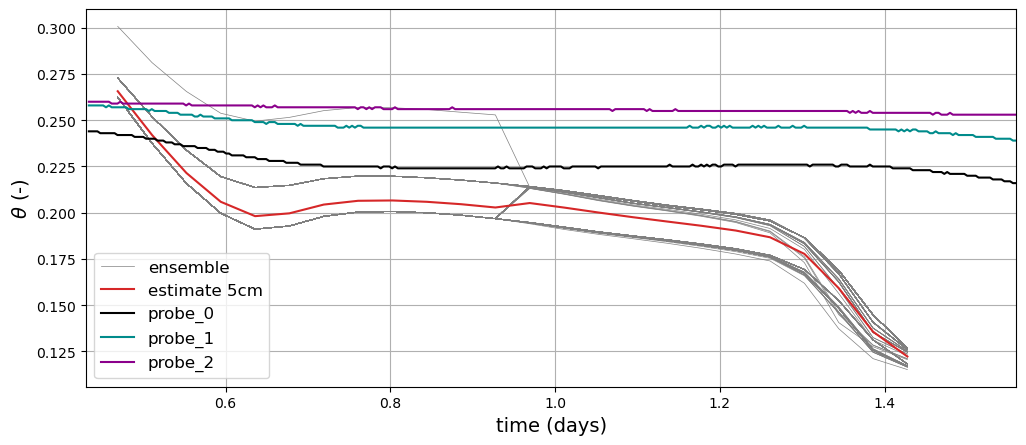

In [32]:
# %% Plot soil moisture (probe vs ensemble)
fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=100)
for n in range(N_ens):
    p, = ax.plot(time, M["M2"][:, n], color="gray", lw=0.5)

e, = ax.plot(time, Mmean[:, 1], color="C3")

smprobe = tahmo.loc[tstart:tend, smcols]
smprobe_time = (smprobe.index - t0).total_seconds() / (24 * 60 * 60)
probes = []
colors = ["k", "DarkCyan", "DarkMagenta"]
for icol, c in zip(smcols, colors):
    a, = ax.plot(smprobe_time, smprobe[icol], c=c)
    probes.append(a)

ax.legend([p, e] + probes,
          ["ensemble", "estimate 5cm"] + [f"probe_{i}" for i in range(3)],
          loc="best", fontsize = 12)

ax.grid(b=True)
ax.set_ylabel(r"$\theta$ (-)", fontsize = 14)
ax.set_xlim(tstart_num, tend_num)
ax.set_xlabel("time (days)", fontsize = 14)

Text(0.5, 0, 'time (days)')

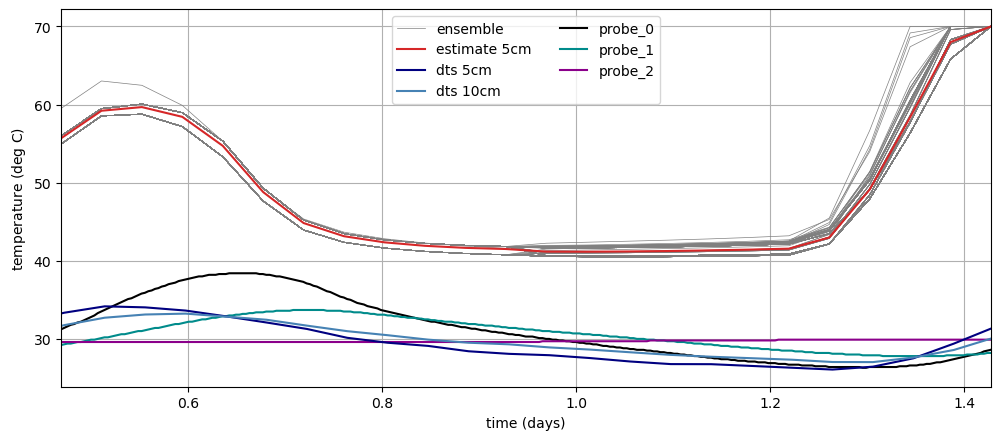

In [33]:
# %% Plot soil temperature (probe vs ensemble)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=100)
for n in range(N_ens):
    p, = ax.plot(time, T["T2"][:, n], color="gray", lw=0.5)

e, = ax.plot(time, Tmean[:, 1], color="C3")

stprobe = tahmo.loc[tstart:tend, stcols]
probes = []
colors = ["k", "DarkCyan", "DarkMagenta"]
for icol, c in zip(stcols, colors):
    a, = ax.plot(smprobe_time, stprobe[icol], c=c)
    probes.append(a)

tc1, = ax.plot(mtime, obsdf["T5"].iloc[:, 0], c="navy")
tc2, = ax.plot(mtime, obsdf["T10"].iloc[:, 0], c="SteelBlue")

ax.legend([p, e, tc1, tc2] + probes,
          ["ensemble", "estimate 5cm", "dts 5cm", "dts 10cm"] +
          [f"probe_{i}" for i in range(3)],
          loc="best", ncol=2)

ax.grid(b=True)
ax.set_ylabel(r"temperature ($\deg$ C)")
ax.set_xlim(time[0], time[-1])
ax.set_xlabel("time (days)")

<hr>

#### STP par?

The first dimension $m$ of the data I think refers to the number of major iterations (or something along those lines). It corresponds to the number of times the Hydrus output prints a different output message with just 2 numbers instead of 3. The $n$ refers to the number of ensembles.

I think we are seeing the development of the values of certain parameters over the model run. I think the final estimate is the best guess of that parameter value. I do not know exactly what these parameters represent. 

In [60]:
# STP Par
STPPar = np.loadtxt(os.path.join(model_ws, "FinallResultsESPar1.txt"))
m, n = STPPar.shape
idx = np.arange(0, m, 4)
par1 = STPPar[idx + 0, :]
par2 = STPPar[idx + 1, :]
par3 = STPPar[idx + 2, :]
par4 = STPPar[idx + 3, :]

par_mean = [
    par1[-1, :].mean(),
    par2[-1, :].mean(),
    par3[-1, :].mean(),
    par4[-1, :].mean(),
]

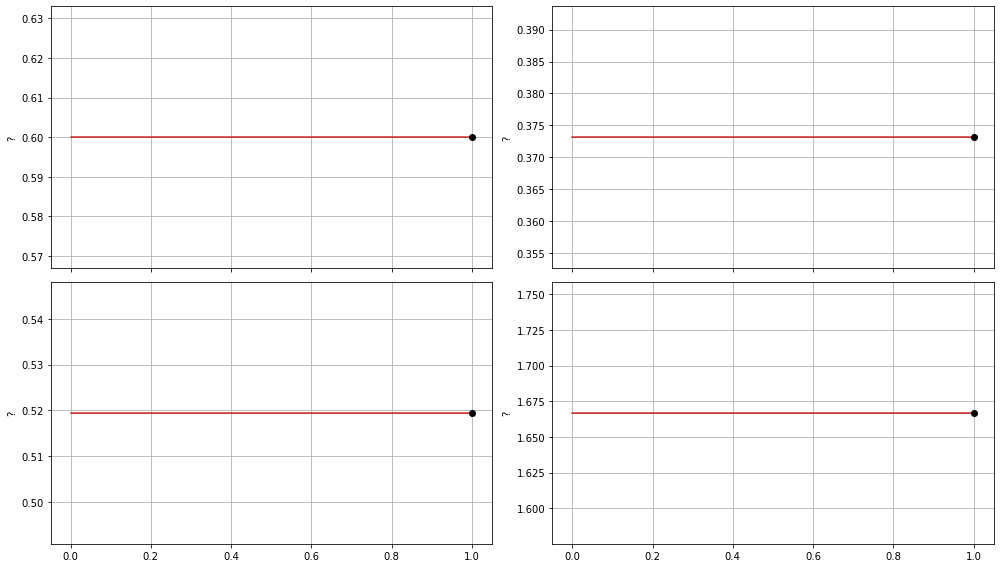

In [61]:
# plot STP parameters
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

for iax, ipar in zip(axes.ravel(), [par1, par2, par3, par4]):
    iax.plot(ipar, lw=0.75, color="gray")  # all ensembles
    iax.plot(ipar.mean(axis=1), lw=1.5, color="C3")  # mean of ensembles over timesteps
    iax.plot(m//4-1, ipar[-1, :].mean(), marker="o", c="k", ls="none") # mean value of final iteration
    iax.set_ylabel("?")
    iax.grid(b=True)
fig.tight_layout()

<hr>

#### SHP par?

Once again we are seeing the development of certain parameter values during the model run. Some are different in different ensembles while others always remain the same. Perhaps some parameters are kept constant while others are varied. I do not know what these parameters represent, except for LAI which is the leaf-area-index.

In [62]:
# SHP Par
SHPPar = np.loadtxt(os.path.join(
    model_ws, "FinallResultsESPar_SHP1.txt"))
m, n = SHPPar.shape
idx = np.arange(0, m, 7)
parh1 = SHPPar[idx + 0, 1:]
parh2 = SHPPar[idx + 1, 1:]
parh3 = SHPPar[idx + 2, 1:]
parh4 = SHPPar[idx + 3, 1:]
parh5 = SHPPar[idx + 4, 1:]
lai = SHPPar[idx + 5, 1:]
vcmax = SHPPar[idx + 6, 1:]

shppars = {
    "parh1": parh1, 
    "parh2": parh2, 
    "parh3": parh3, 
    "parh4": parh4, 
    "parh5": parh5, 
    "lai": lai, 
    "vcmax": vcmax
}

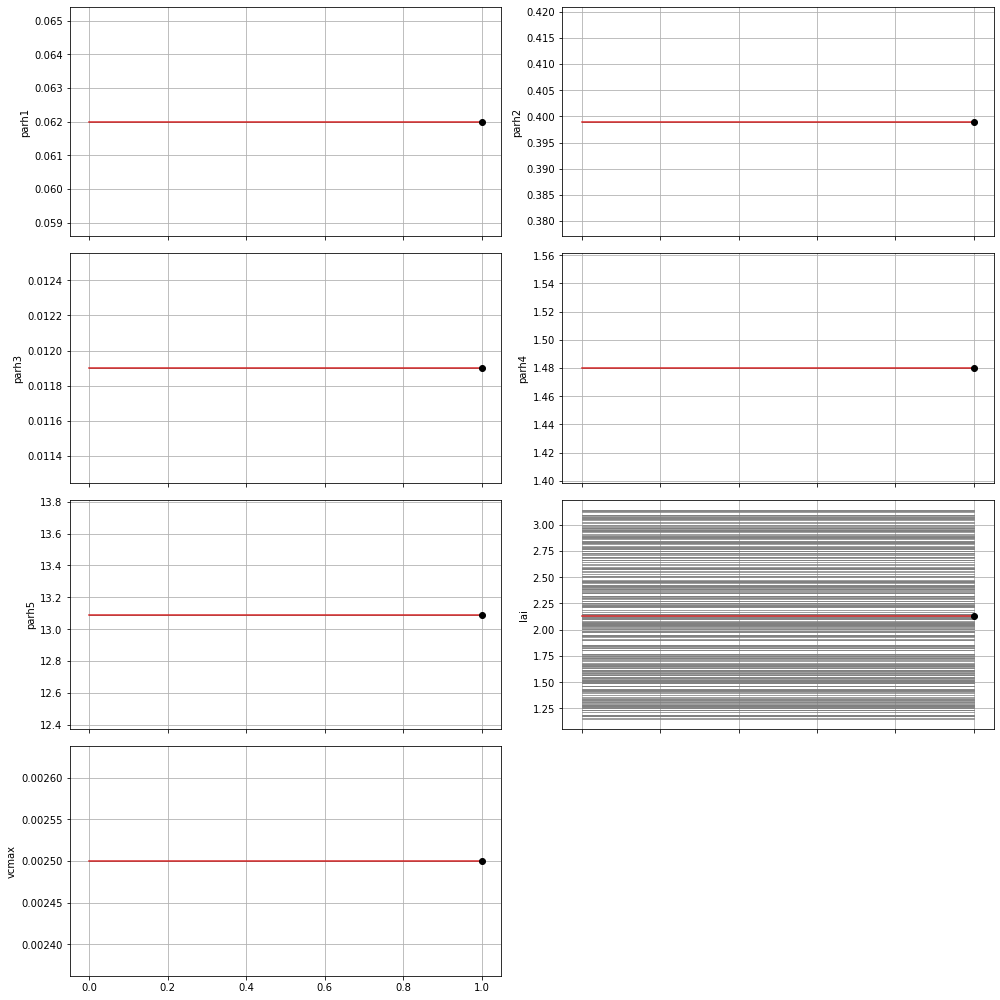

In [63]:
# plot SHP parameters
fig, axes = plt.subplots(4, 2, figsize=(14, 14), sharex=True)

for iax, lbl in zip(axes.ravel(), shppars.keys()):
    ipar = shppars[lbl]
    iax.plot(ipar, lw=0.75, color="gray")  # all ensembles
    iax.plot(ipar.mean(axis=1), lw=1.5, color="C3")  # mean of ensembles over timesteps
    iax.plot(m//7-1, ipar[-1, :].mean(), marker="o", c="k", ls="none") # mean value of final iteration
    iax.set_ylabel(lbl)
    iax.grid(b=True)
axes[-1, -1].set_visible(False)
fig.tight_layout()

<hr>

#### Cable depths

I have not yet been able to figure out where the cable depths are defined. They might be hard-coded in the Hydrus source code and varied in each ensemble.

In [64]:
# Cable depths
cable_depths = np.loadtxt(os.path.join(model_ws, "FinalCableDepths1.txt"))
m, n = cable_depths.shape
idx = np.arange(0, m, 2)
cable1 = cable_depths[idx + 0, 1:]
cable2 = cable_depths[idx + 1, 1:]

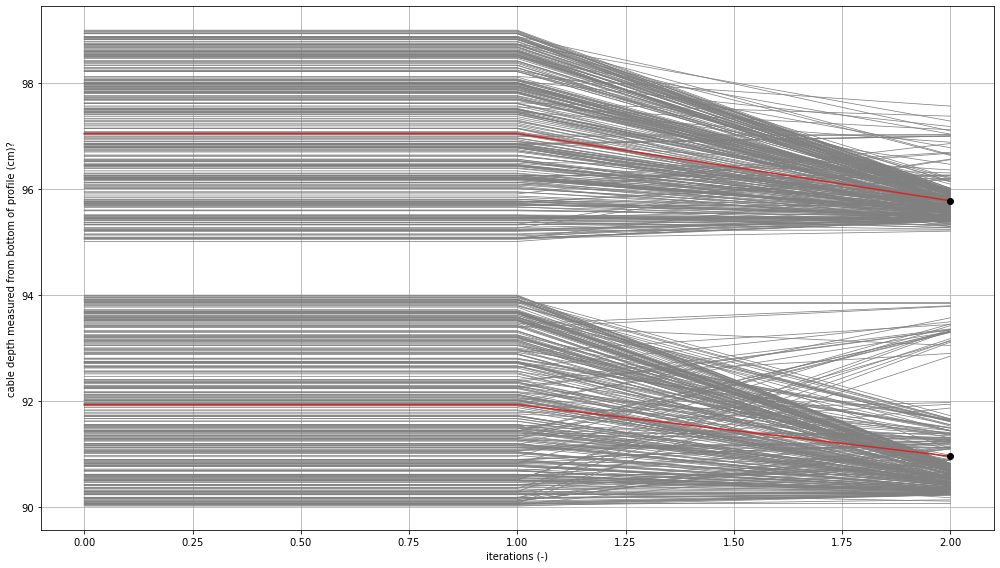

In [65]:
# plot cables depths
fig, ax = plt.subplots(1, 1, figsize=(14, 8), sharex=True)

for ipar in [cable1, cable2]:
    ax.plot(ipar, lw=0.75, color="gray")  # all ensembles
    ax.plot(ipar.mean(axis=1), lw=1.5, color="C3")  # mean of ensembles over timesteps
    ax.plot(m//2-1, ipar[-1, :].mean(), marker="o", c="k", ls="none") # mean value of final iteration
ax.set_ylabel("cable depth measured from bottom of profile (cm)?")
ax.set_xlabel("iterations (-)")
ax.grid(b=True)
fig.tight_layout()

<hr>

#### Flux

These are fluxes of some kind, though I have not yet figured out what each flux represents. Some seem to exhibit a similar pattern to the final soil temperature result, which could provide some clues as to why the temperatures are getting so high in the model.

In [66]:
# Flux
flux = np.loadtxt(os.path.join(model_ws, "FinallResultsESFlux1.txt"))
m, n = flux.shape
idx = np.arange(0, m, 5)
flux_hv = flux[idx + 0, 1:]
flux_lev = flux[idx + 1, 1:]
flux_hg = flux[idx + 2, 1:]
flux_leg = flux[idx + 3, 1:]
flux_g = flux[idx + 4, 1:]

flux_dict = {
    "hv": flux_hv,
    "lev": flux_lev,
    "hg": flux_hg,
    "leg": flux_leg,
    "g": flux_g
}

tflux = flux[idx, 0]

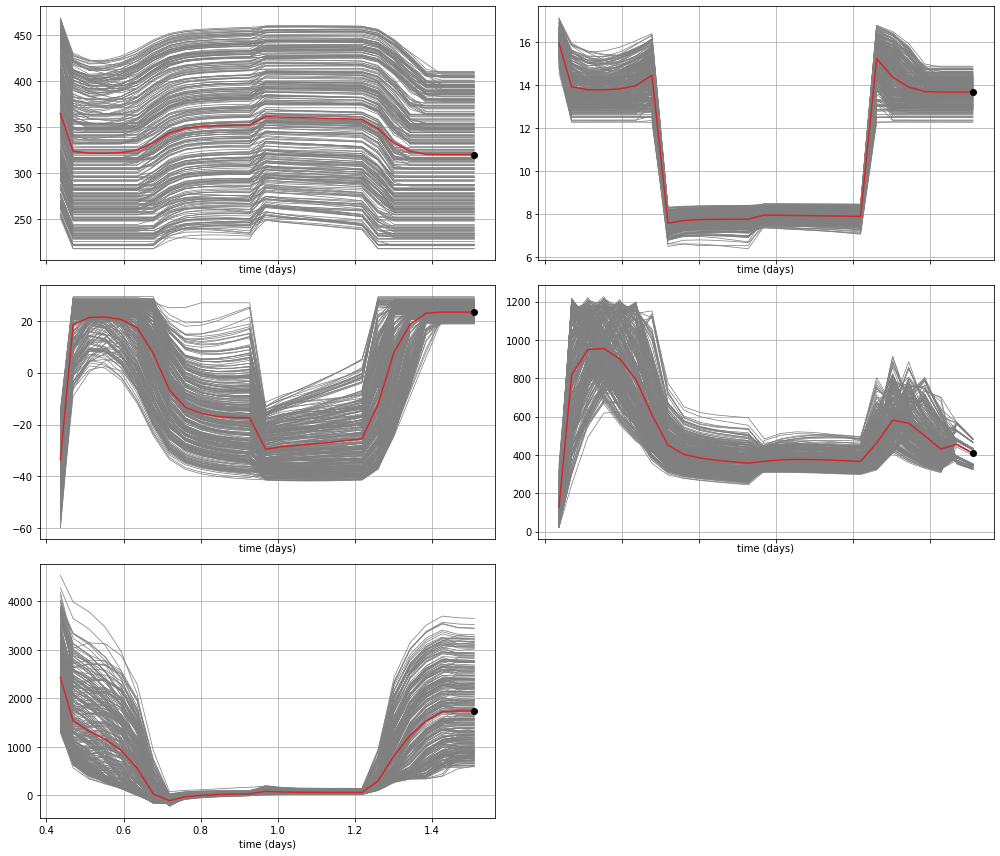

In [67]:
# plot fluxes
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)

for iax, lbl in zip(axes.ravel(), flux_dict.keys()):
    ipar = flux_dict[lbl]
    
    iax.plot(tflux, ipar, lw=0.75, color="gray")  # all ensembles
    iax.plot(tflux, ipar.mean(axis=1), lw=1.5, color="C3")  # mean of ensembles over timesteps
    iax.plot(tflux[-1], ipar[-1, :].mean(), marker="o", c="k", ls="none") # mean value of final iteration
    iax.set_ylabel("")
    iax.set_xlabel("time (days)")
    iax.grid(b=True)

axes[-1, -1].set_visible(False)

fig.tight_layout()

<hr>

#### Profile
The profile data seems to contain soil moisture and temperature development over time at a point. I think the y-axis is the elevation of the top 22 layers (each 1 cm) of the profile.

In [68]:
# Profile
profile = np.loadtxt(os.path.join(model_ws, "FinalProfile1.txt"))

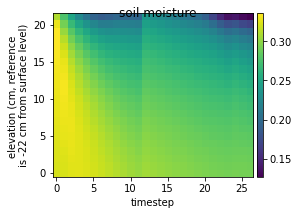

In [69]:
# profile
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ms = ax.matshow(profile[::2, 1:].T)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
ax.yaxis.set_inverted(False)
ax.xaxis.set_ticks_position("bottom")
plt.colorbar(ms, cax=cax)
fig.suptitle("soil moisture")
ax.set_xlabel("timestep")
ax.set_ylabel("elevation (cm, reference \nis -22 cm from surface level)")
fig.tight_layout()

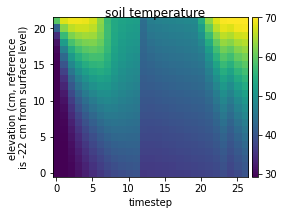

In [70]:
# profile
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ms = ax.matshow(profile[1::2, 1:].T)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
ax.yaxis.set_inverted(False)
ax.xaxis.set_ticks_position("bottom")
plt.colorbar(ms, cax=cax)
fig.suptitle("soil temperature")
ax.set_xlabel("timestep")
ax.set_ylabel("elevation (cm, reference \nis -22 cm from surface level)")
fig.tight_layout()

<hr>

#### Tuning

These are some parameters that are used for "tuning" something, but I am not sure what.

In [71]:
# %% Tuning
tuning = np.loadtxt(os.path.join(model_ws, "FinalTuning1.txt"))

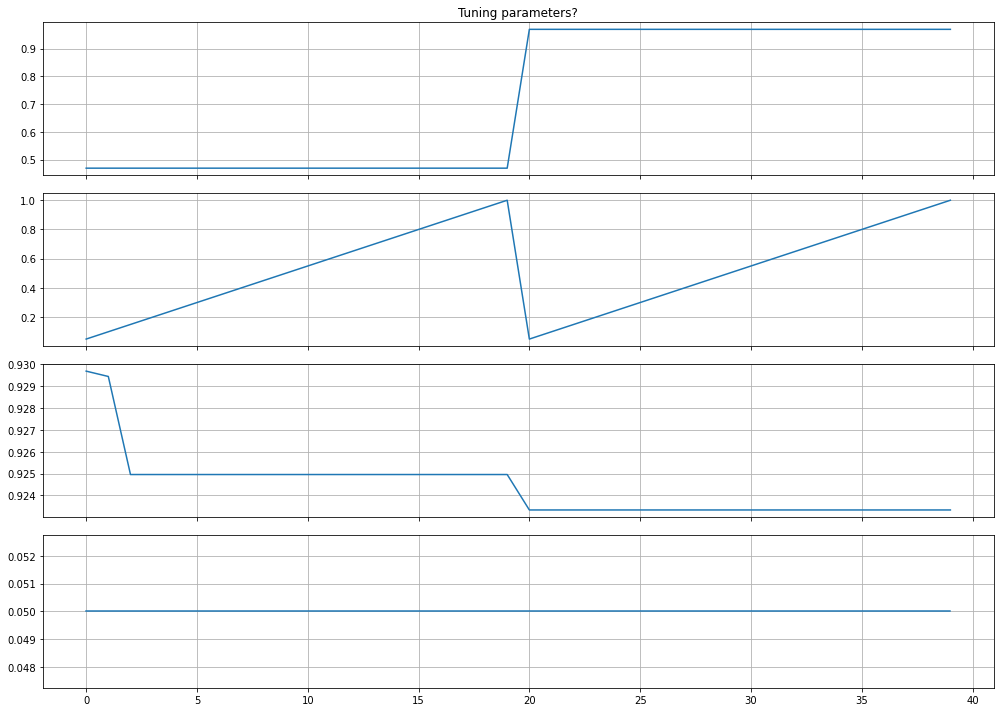

In [72]:
fig, ax = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

for i in range(4):
    ax[i].plot(tuning[:, i])
    ax[i].grid(b=True)

ax[0].set_title("Tuning parameters?")
fig.tight_layout()

Comparison plot

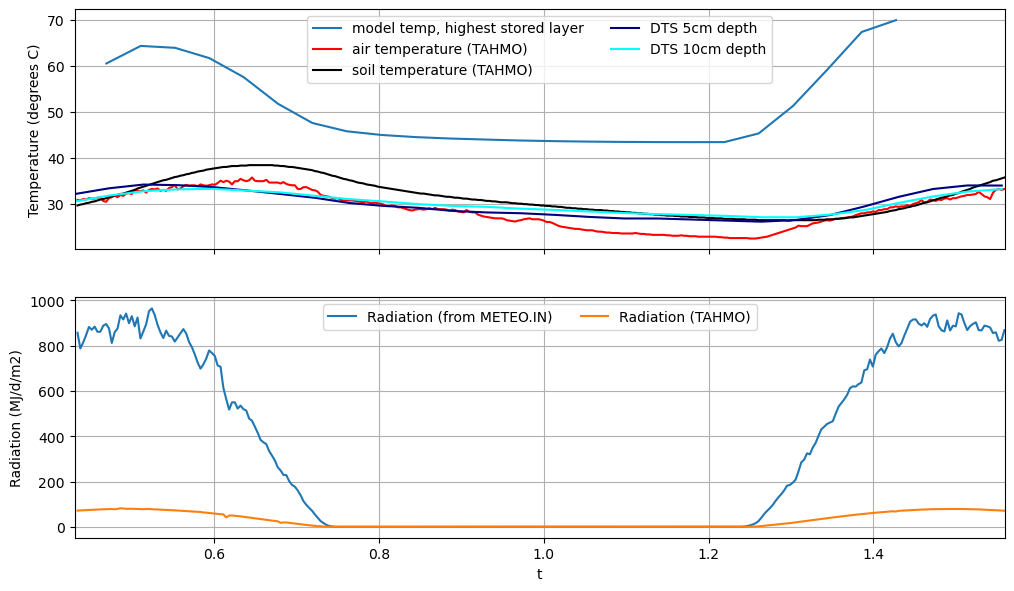

In [73]:
# %% Comparing METEO input and DTS and probe and model temp

f = os.path.join(model_ws, r"C:/Users/CWPGHANA/anaconda3/dtscamp2020/DTS_GHANA-GITHUB/scripts/soilmoisture/METEO1.IN")

df = pd.read_csv(f, skiprows=25, header=None, skipfooter=1, sep="\s+",
                 names=['t', "Rad", "TMax", "TMin", "RHMean",
                        "Wind", "SunHours"], engine="python")

df = df.set_index("t")
fig, axes = plt.subplots(2, 1, figsize=(12, 7), dpi=100, sharex=True)

e, = axes[0].plot(time, Tmean[:, 1], label="model temp, highest stored layer")

tahmo_time = (tahmo.loc[tstart:tend].index -
              t0).to_numpy() / np.timedelta64(1, "D")
axes[0].plot(tahmo_time, tahmo.loc[tstart:tend,
                                   'temperature (degrees Celsius)'], c="r",
             label="air temperature (TAHMO)")
axes[0].plot(tahmo_time, tahmo.loc[tstart:tend, stcols[0]],
             c="k", label="soil temperature (TAHMO)")
axes[0].plot(mtime, obsdf["T5"].iloc[:, 0], c="navy", label="DTS 5cm depth")
axes[0].plot(mtime, obsdf["T10"].iloc[:, 0], c="cyan", label="DTS 10cm depth")
# df["TMax"].plot(ax=axes[0], label="TMax (from METEO.IN)")
# df["TMin"].plot(ax=axes[0], label="TMin (from METEO.IN)")

df["Rad"].plot(ax=axes[1], label="Radiation (from METEO.IN)")
axes[1].plot(tahmo_time, tahmo.loc[tstart:tend,
                                   "radiation (W/m2)"] * (24 * 60 * 60 * 1e-6),
             label="Radiation (TAHMO)")

for iax in axes:
    iax.legend(loc="best", ncol=2)
    iax.grid(b=True)

axes[0].set_xlim(tstart_num, tend_num)
axes[0].set_ylabel("Temperature (degrees C)")
axes[1].set_ylabel("Radiation (MJ/d/m2)");

In [74]:
save_soiltemp = pd.DataFrame(index=time, data=Tmean[:, 1], columns=["Soiltemp_Hydrus"])
tahmo_cols = stcols + ['temperature (degrees Celsius)', "radiation (W/m2)"]
save_tahmo = tahmo.loc[tstart:tend]
save_obs = obsdf.iloc[:, 1:3]

# save_soiltemp.to_csv("csv_fannor/model_soil_temperature.csv")
# save_tahmo.to_csv("csv_fannor/tahmo_data.csv")
# save_obs.to_csv("csv_fannor/dts_temp_obs.csv")

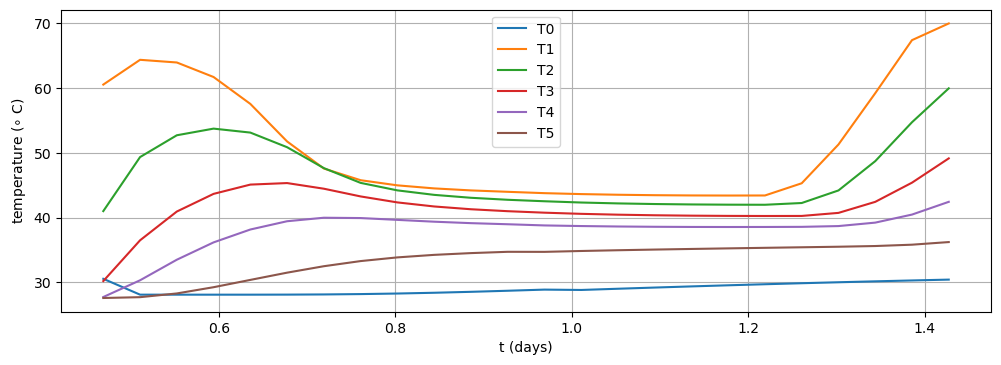

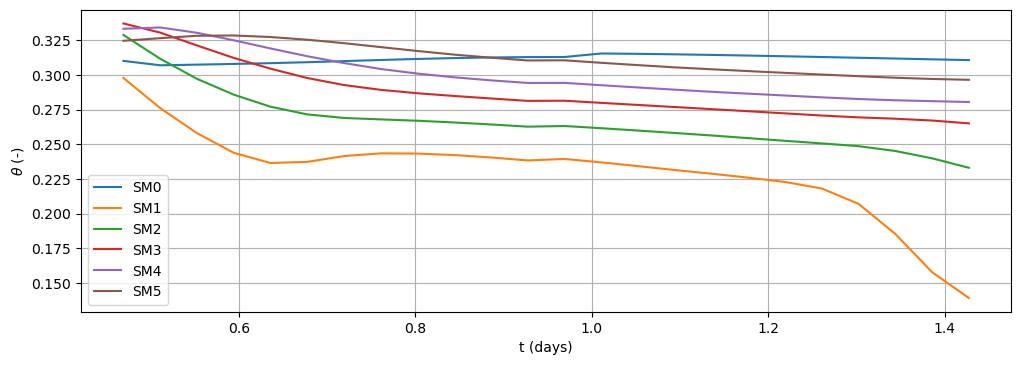

In [75]:
# stored soil temperature and moisture at 6 depths:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
for i in range(6):
    e, = ax.plot(time, Tmean[:, i], label=f"T{i}")
ax.legend(loc="best")
ax.grid(b=True)
ax.set_xlabel("t (days)")
ax.set_ylabel("temperature ($\circ$ C)")


fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
for i in range(6):
    e, = ax.plot(time, Mmean[:, i], label=f"SM{i}")
ax.legend(loc="best")
ax.grid(b=True)
ax.set_xlabel("t (days)")
ax.set_ylabel(r"$\theta$ (-)");

In [76]:
if "SELECTOR" in writelist:
    # sand, clay and silt percentage
    sand_percentage = np.random.rand(ensemble_size)
    cor = 0.0
    sand = sand_percentage * 55 + 10  # (55)
    silt = (100 - sand) * (0.9 * np.random.rand() + 0.1)
    clay = 100 - silt - sand
    
    # bulk density estimate
    bulk_density = 1.2 + 0.5 * (sand_percentage * 0.3 + (1 - cor) * np.random.rand()) # (1.2)

    # alpha bounds
    alpha1 = np.array([0, 100])
    alpha2 = np.array([0.27, 0.96])
    
    # interpolator function using univariate spline
    spl = interpolate.UnivariateSpline(alpha1, alpha2, k=1)
    
    # create <ensemble_size> files
    for i in (tqdm(range(ensemble_size), desc="SELECTOR") if progress_bar
              else range(ensemble_size)):
        
        # Get soil characteristics (I think only porosity?) from Rosetta? 
        # I'm not entirely sure yet what is being calculated in this section...
        # TODO: get_roeseta_params() IS NOT WORKING! ALWAYS GETS THE SAME FILE resul.txt
        # which I took from Jianzhi Dong's files
        soil_hydrology = get_roeseta_params(sand[i], silt[i], bulk_density[i],
                                            "cm", "day")
        
        # Jianzhi Dong uses soil_hydrology calculated above as input for the materials dictionary, 
        # I have left that out for now. But the commmented code below shows how that would work:
        # materials_df = pd.DataFrame(columns=["thr", "ths", "Alfa", "n", "Ks", "l"],
        #                     data=np.atleast_2d(soil_hydrology),
        #                    index=[0])
        # # the key 'water' is used because the write_method I took from Pydrus contains a hard-coded reference to it.
        # materials = {"water": materials_df}  
                
        porosity = 1 - soil_hydrology[1]
        alpha = spl(sand[i])
        
        q = sand[i] / 100
        if q < 0.2:
            lab_0 = 3
        else:
            lab_0 = 2

        lab_w = 0.594  # water
        lab_q = 7.7  # quartz?

        lab_s = lab_q**q * lab_0**(1 - q)
        lab_sat = lab_s**porosity * lab_w**(1 - porosity)  # saturated thermal conductivity?
        
        # soil thermal properties (I am unsure what these parameters represent exactly)
        soil_thermal = np.array([porosity,
                                 0.,
                                 0.001,
                                 q,
                                 alpha,
                                 lab_sat,
                                 1.83327e+014 * 1.,
                                 1.8737e+014,
                                 3.12035e+014])

        # write selector.in
        write_selector(basic_info, time_info, times_list, water_flow,
                       materials, heat_transport_info, heat_params,
                       n_materials=1, n_layers=1,
                       fname=f"SELECTOR_LU{i+1}.IN", ws=input_ws,
                       verbose=verbose)

In [64]:
x = np.([6.44316920e-05 1.14230936e-04 1.64030181e-04 ... 6.28308571e+00
 6.28313551e+00 6.28318531e+00])
y = np.array([None])
for i in range(126170):
    y[i] = np.float(x[i])
print(y)

SyntaxError: invalid syntax (<ipython-input-64-2da55a1f46ef>, line 1)